[585. 650. 715.] nm


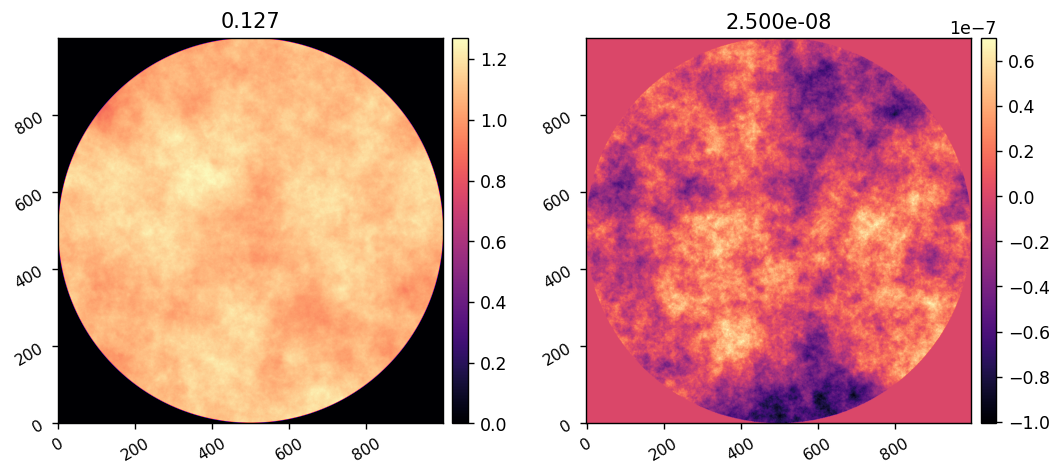

array(2.5e-08)

In [1]:

import numpy as np
import astropy.units as u
from datetime import datetime
today = int(datetime.today().strftime('%Y%m%d'))
from importlib import reload

from matplotlib.patches import Circle

import ray

import scoobpsf
import scoobpsf.utils as utils
from scoobpsf.math_module import xp, _scipy, ensure_np_array
from scoobpsf.imshows import imshow1, imshow2, imshow3
import scoobpsf.compact_scoob as scoob
import scoobpsf.parascoob as parascoob
import scoobpsf.dm as dm

import lina

nwaves = 3
bw = 0.2
wavelength_c = 650*u.nm
wavelengths = np.linspace(wavelength_c*(1 - bw/2), wavelength_c*(1 + bw/2), nwaves)
print(wavelengths)

reload(utils)
npix = 1000
WFE, mask = utils.generate_wfe(diam=10*u.mm,
                                npix=npix, oversample=1,
                                wavelength=wavelength_c,
                                opd_index=2.75, amp_index=3,
                                opd_rms=25*u.nm, amp_rms=0.05,
                                remove_modes=12)

wfe_amp = xp.abs(WFE)
wfe_opd = xp.angle(WFE)*wavelength_c.to_value(u.m)/2/np.pi
rms_amp = xp.sqrt(xp.mean(xp.square(wfe_amp[mask]-1)))
rms_opd = xp.sqrt(xp.mean(xp.square(wfe_opd[mask])))
imshow2(wfe_amp, wfe_opd,  f'{rms_amp:.3f}', f'{rms_opd:.3e}')
lina.utils.rms(wfe_opd[mask])

In [2]:
ray_scoob = ray.remote(scoob.CORO)

actors = []

for i in range(nwaves):
    actors.append(ray_scoob.options(num_cpus=4, num_gpus=1/6).remote(wavelength=wavelengths[i]))



2024-05-17 14:39:49,763	INFO worker.py:1636 -- Started a local Ray instance.


(CORO pid=1653643) Oversampling > 2x suggested for reliable results in Fresnel propagation.


In [3]:
reload(parascoob)
model = parascoob.ParallelizedScoob(actors=actors)

(CORO pid=1653643) influence function sampling 31.914893617021274
(CORO pid=1653643) Using the influence function supplied.
(CORO pid=1653643) Including factor of 2 from reflection when computing OPD.
ParallelizedScoob Initialized!


In [4]:
model.set_actor_attr('WFE', WFE)
psf = model.snap()

model.set_actor_attr('use_fpm', True)
coro_im = model.snap()


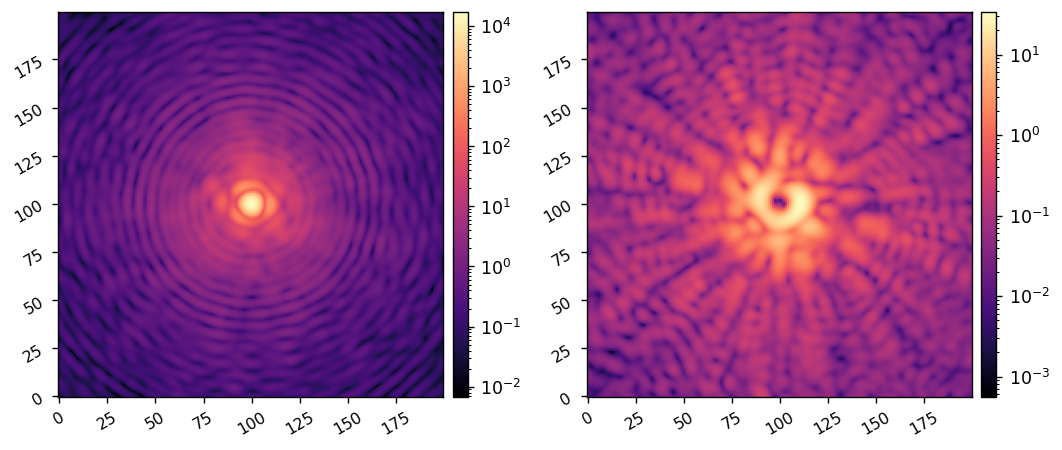

In [5]:
imshow2(psf, coro_im, lognorm=True)


In [6]:
model.use_llowfsc()

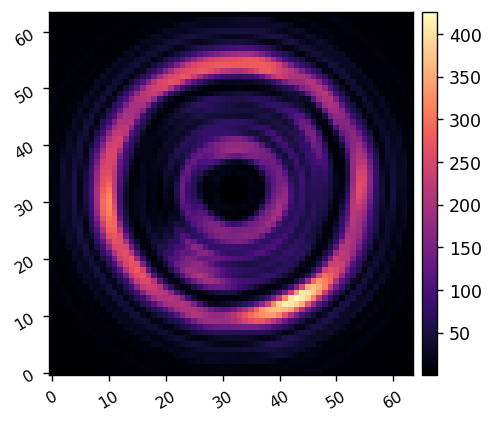

In [8]:
llowfsc_im = model.snap()
imshow1(llowfsc_im)

influence function sampling 31.914893617021274
Using the influence function supplied.
Including factor of 2 from reflection when computing OPD.


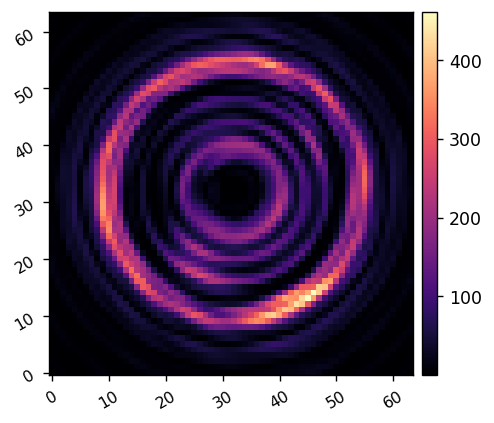

In [12]:
mono_model = scoob.CORO(wavelength=wavelength_c)
mono_model.WFE = WFE
mono_model.use_fpm = True
mono_model.use_llowfsc()
mono_im = mono_model.snap()

imshow1(mono_im)

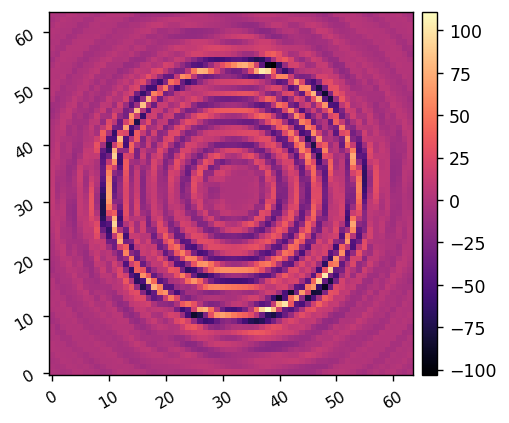

In [13]:
imshow1(llowfsc_im - mono_im)